## Explain model comparison toy example

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import ClassificationSingleLayerMDN, Trainer, UnivariateMogMDN
from model_comparison.models import PoissonModel, NegativeBinomialModel

from delfi.distribution.mixture import MoG

## Set up Poisson and Negative Binomial model

In [2]:
seed = 1
rng = np.random.RandomState(seed=seed)
sample_size = 100
ntrain = 100000

k2 = 5.
theta2 = 2.0

k3 = 2.
theta3 = .8

# then the scale of the Gamma prior for the Poisson is given by
k1 = 2.0
theta1 = (k2 * theta2 * k3 * theta3) / k1
print(theta1)

model_poisson = PoissonModel(sample_size=sample_size, seed=seed, n_workers=2)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed, n_workers=2)

8.0


## Generate parameters from the priors 

In [3]:
# from Gamma prior for Poisson 
params_poi = rng.gamma(shape=k1, scale=theta1, size=int(ntrain / 2))

# from two Gamma priors for indirect Poisson-Gamma Sampling.
params_nb = np.vstack((rng.gamma(shape=k2, scale=theta2, size=int(ntrain / 2)), 
                       rng.gamma(shape=k3, scale=theta3, size=int(ntrain / 2)))).T

## Generate data from models and calculate summary stats

In [4]:
data_poi = model_poisson.gen(params_poi)
data_nb = model_nb.gen(params_nb)

In [5]:
# shuffle and set up model index target vector 
x = np.vstack((data_poi, data_nb))

# define model indices
m = np.hstack((np.zeros(data_poi.shape[0]), np.ones(data_nb.shape[0]))).squeeze().astype(int).tolist()

# calculate summary stats
sx = calculate_stats_toy_examples(x)
sx_zt, training_norm = normalize(sx)

## Set up the NN and train it 

[epoch 0100] loss: 0.0771
[epoch 0200] loss: 0.0642


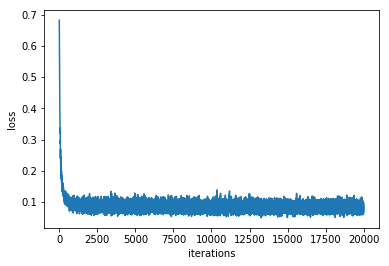

In [6]:
model = ClassificationSingleLayerMDN(ndim_input=2, n_hidden=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 200 
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Observe Poisson data and predict underlying model 

In [7]:
# generate a single sample of Poisson data, with lambda at the mean of the model prior 
x_obs = rng.poisson(lam=k1*theta1, size=sample_size)
# calculate stats 
sx_obs = calculate_stats_toy_examples(x_obs)
# normalize using training data normalization 
sx_obs_zt, training_norm = normalize(sx_obs, training_norm)

# predict 
softmax = nn.Softmax(dim=1)
out_act = model(Variable(torch.Tensor(sx_obs_zt)))
p_vec = softmax(out_act).data.numpy().squeeze()
print('P(poisson | data) = {:.2f}'.format(p_vec[0]))

P(poisson | data) = 1.00


## Given the predicted underlying model we can learn the posterior of its parameters

In [8]:
# define a network to approximate the posterior with a MoG 
model_params_mdn = UnivariateMogMDN(ndim_input=2, n_hidden=10, n_components=3)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [9]:
# calculate stats for poisson model 
sx_poi = calculate_stats_toy_examples(data_poi)

# normalize data 
sx_poi_zt, data_norm = normalize(sx_poi)

# normalize prior params 
params_poi_zt, prior_norm = normalize(params_poi)

In [10]:
loss_trace = trainer.train(sx_poi_zt, params_poi_zt, n_epochs=100, n_minibatch=int(ntrain / 200))

[epoch 0100] loss: -1.9576


In [11]:
n_thetas = 1000
thetas_poisson = np.linspace(0, 30, n_thetas)

In [12]:
# normalize the observed data 
sx_obs_zt, data_norm = normalize(sx_obs, data_norm)

## Get delfi MoG for plotting and inverse z transform 

In [13]:
(out_alpha, out_sigma, out_mu) = model_params_mdn(Variable(torch.Tensor(sx_obs_zt)))

# convert to dd format 
a = out_alpha.data.numpy().squeeze().tolist()
ms = [[m] for m in out_mu.data.numpy().squeeze().tolist()]
Ss = [[[s**2]] for s in out_sigma.data.numpy().squeeze().tolist()]

# set up dd MoG object 
mog_posterior_delfi_zt = MoG(a=a, ms=ms, Ss=Ss)

In [14]:
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])
posterior_pdvalues = mog_posterior_delfi.eval(x=thetas_poisson.reshape(1000, -1), log=False)

## Get true posterior

In [15]:
# get analytical gamma posterior 
k_post = k1 + np.sum(x_obs)

# use the posterior given the summary stats, not the data vector 
scale_post = 1. / (sample_size + theta1**-1)

# somehow we have to scale with N again, why? because the scale is changed due to s(x) by 1/N  
true_post_poisson = gamma.pdf(x=thetas_poisson, a=k_post, scale=scale_post)

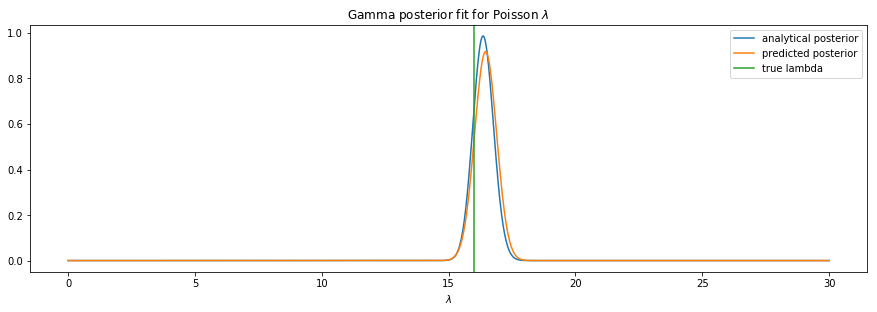

In [16]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title(r'Gamma posterior fit for Poisson $\lambda$')
# plt.plot(thetas_poisson, gamma_prior.pdf(thetas_poisson), label='prior')
plt.plot(thetas_poisson, true_post_poisson, label='analytical posterior')
plt.plot(thetas_poisson, posterior_pdvalues, label='predicted posterior')
plt.axvline(x=k1 * theta1, color="C2", label='true lambda')
plt.legend()
plt.xlabel(r'$\lambda$');
